In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import stumpy

In [3]:
steam_df = pd.read_csv("/kaggle/input/example-cardio-signal-ecg/output_ecg.csv",delimiter=';')
#steam_df['Data']
#pd.to_datetime(steam_df['Data'],dayfirst='True')

steam_df.head()

,time,ecg_value
0,0.000,496
1,0.001,496
2,0.002,497
3,0.003,498
4,0.004,498


In [4]:
steam_df = steam_df.astype(float)

y = steam_df['ecg_value']
x = steam_df.index
#x = steam_df['time']
steam_df.head()

,time,ecg_value
0,0.000,496.0
1,0.001,496.0
2,0.002,497.0
3,0.003,498.0
4,0.004,498.0


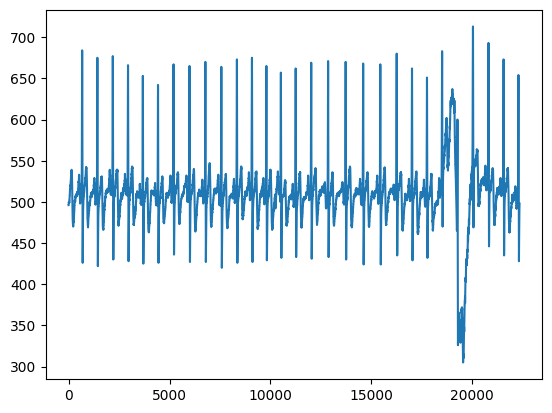

In [5]:
plt.plot(x,y)

# detrending

In [6]:
# модули для обработки временных рядов (убрать тренд и аппроксимировать)
class Detrending:
  def plot(t,y,slope,intercept):
    fig = plt.figure(figsize=(10,7))
    ax = plt.subplot(111)
    plt.scatter(t,y, s=5)
    plt.plot(t, slope*t + intercept, 'r',
             label='y={:.2f}x+{:.2f}'.format(slope,intercept))
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.xlabel('time')
    plt.ylabel('Y')
    plt.show()

  def line_fit(t,y):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
    #line = slope*t + intercept
    return slope, intercept

  def trend_off(t,y):
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(t,y)
    line = slope*t + intercept

    y_nontrend = y-line
    return y_nontrend

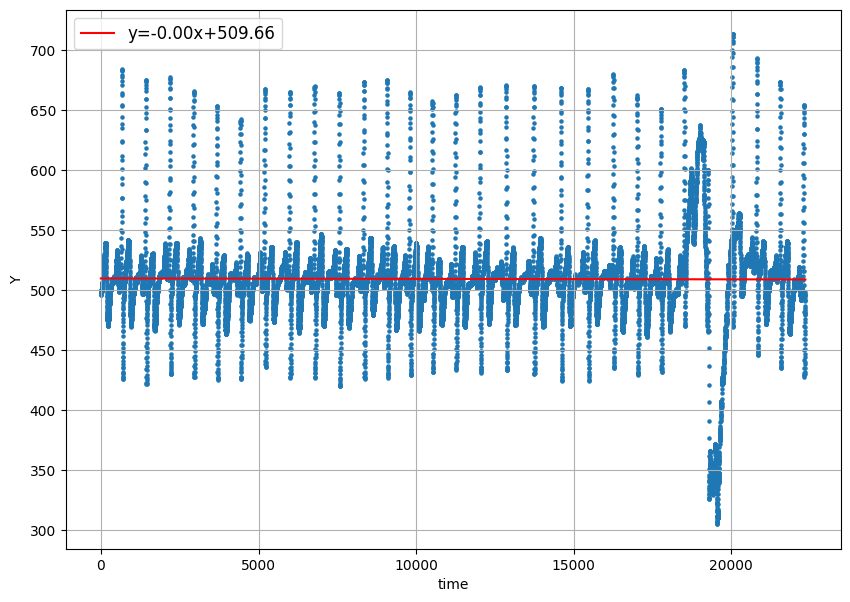

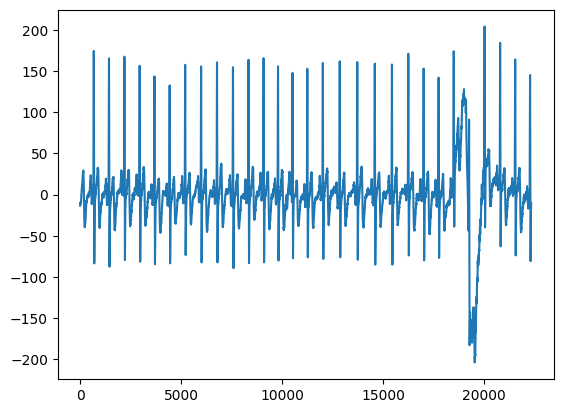

In [8]:
slope, intercept = Detrending.line_fit(x, y)
Detrending.plot(x,y,slope, intercept)

y = Detrending.trend_off(x,y)
plt.plot(x,y)

# Fourier filtering

In [16]:
from numpy.fft import *

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

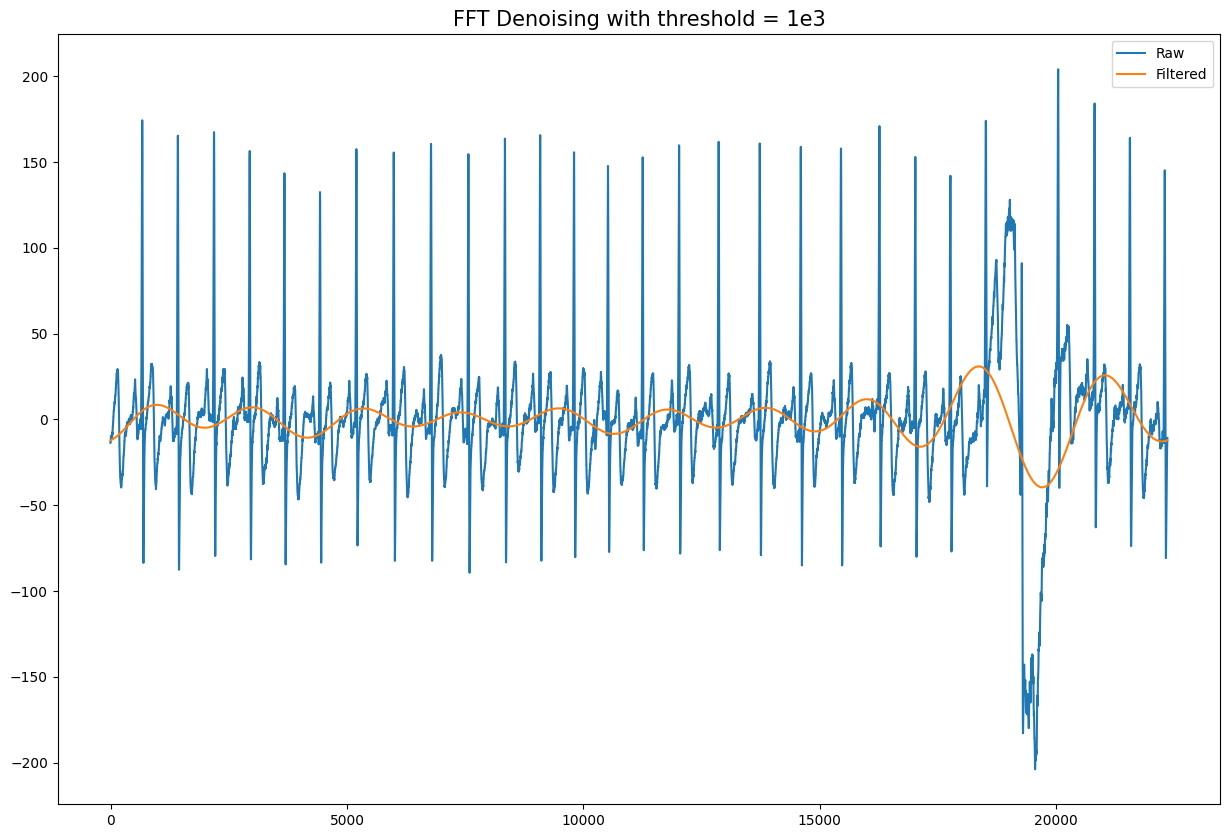

In [28]:
filtered = filter_signal(y, threshold=500)
plt.figure(figsize=(15, 10))
plt.plot(y, label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e3", size=15)
plt.show()

# enveloping

In [41]:
#from scipy.fft import fft, ifft
def my_func_hilbert(x):
    N = len(x)
    xf = rfft(x)
    xf[1:N//2] *= 2
    if N % 2 == 1:
        xf[N//2] *= 2
    xf[N//2 + 1:] = 0
    xa = irfft(xf)
    #assert np.allclose(xa.real, x, atol=1e-10, rtol=1e-10)
    return xa

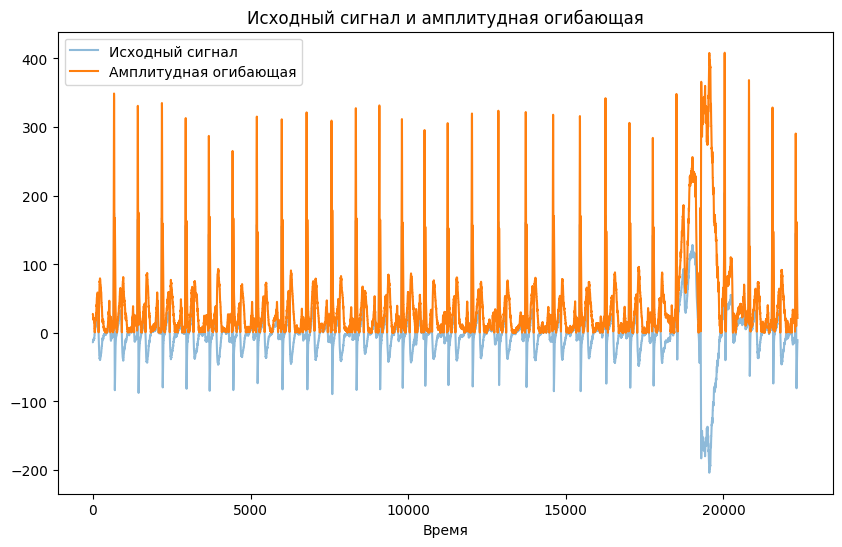

In [43]:
# Применяем преобразование Гильберта
analytic_signal = my_func_hilbert(y)
amplitude_envelope = np.abs(analytic_signal)  # Используем амплитуду для амплитудной огибающей

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Исходный сигнал', alpha=0.5)
plt.plot(x, amplitude_envelope, label='Амплитудная огибающая')


plt.title('Исходный сигнал и амплитудная огибающая')
plt.xlabel('Время')
plt.legend()

plt.show()

# Stumpy library

In [44]:
y_new = y - filtered

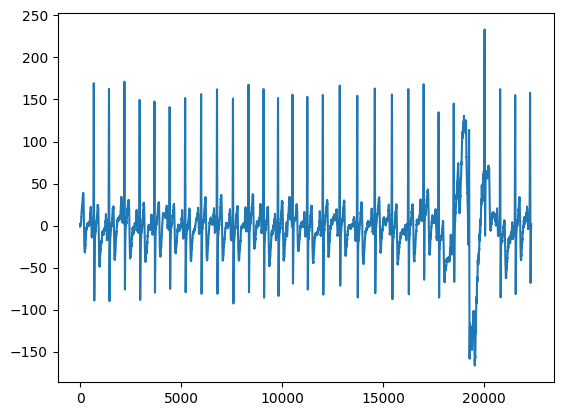

In [46]:
plt.plot(x,y_new)

In [45]:
m = 650
matrix_profile = stumpy.stump(y_new, m)
matrix_profile

mparray([[4.624162824323349, 8412, -1, 8412],
         [4.656131022307386, 8413, -1, 8413],
         [4.6759532908068016, 8415, -1, 8415],
         ...,
         [2.9887972277840773, 3081, 3081, -1],
         [2.997678158573425, 3082, 3082, -1],
         [3.005873233509156, 3083, 3083, -1]], dtype=object)

In [47]:
matrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 'profile index', 'left profile index', 'right profile index'])

best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motifmatrix_profile_df = pd.DataFrame(matrix_profile, columns=['profile', 'profile index', 'left profile index', 'right profile index'])

matrix_profile_df.tail(10)

,profile,profile index,left profile index,right profile index
21691,2.943048,3074,3074,-1
21692,2.946065,3075,3075,-1
21693,2.953138,3076,3076,-1
21694,2.959557,3077,3077,-1
21695,2.963771,3078,3078,-1
21696,2.970619,3079,3079,-1
21697,2.981989,3080,3080,-1
21698,2.988797,3081,3081,-1
21699,2.997678,3082,3082,-1
21700,3.005873,3083,3083,-1


In [49]:
best_motif = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].min()]
best_motif

,profile,profile index,left profile index,right profile index
12838,1.906684,15425,10497,15425
15425,1.906684,12838,12838,16996


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

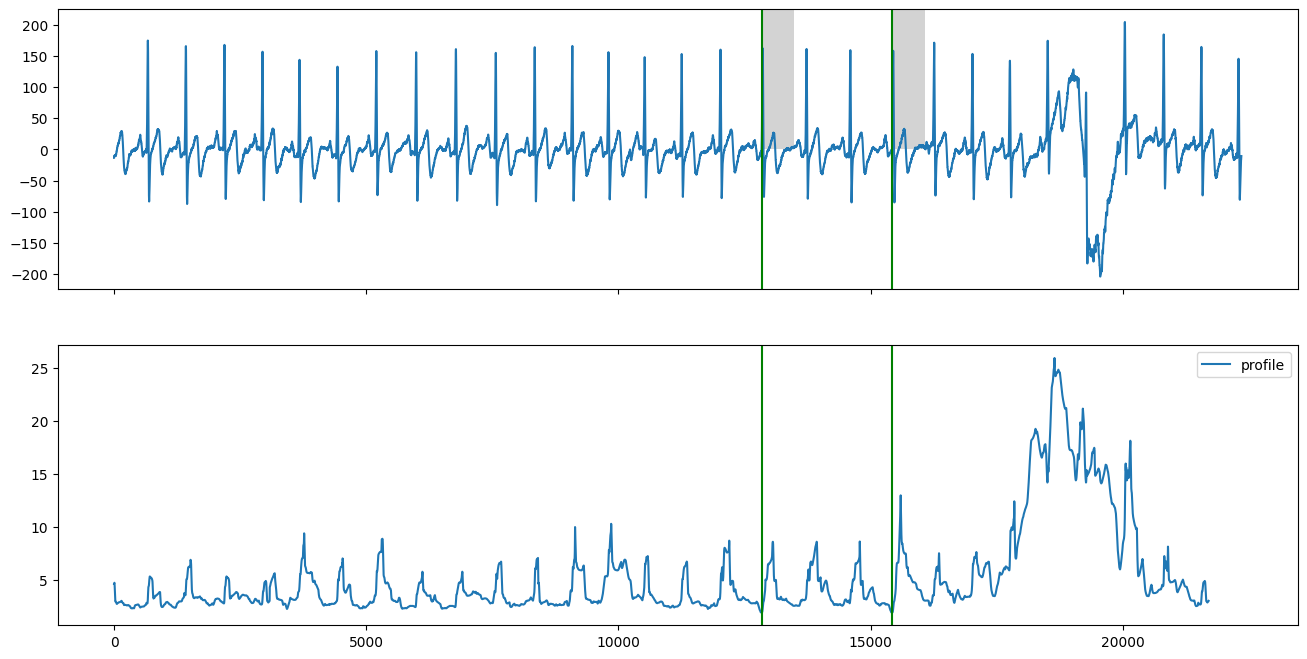

In [50]:
profile_df = matrix_profile_df[['profile']]

fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])

for idx in best_motif.index.to_list():
    g1.axvline(x=idx, color="green")
    g2.axvline(x=idx, color="green")
    rect = Rectangle((idx, 0), m, 700, facecolor="lightgrey")
    g1.add_patch(rect)

Upload txt file OpenSingal format, transform to dataframe pandas format 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

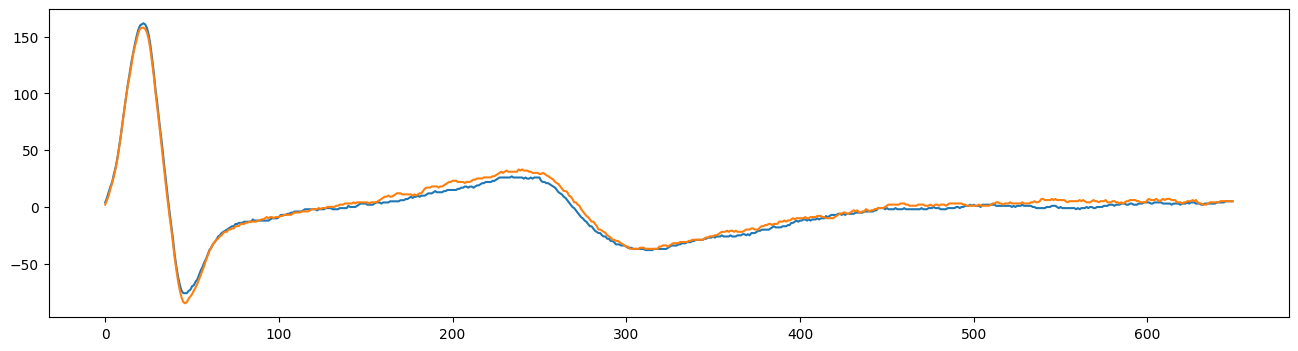

In [51]:
fig, ax = plt.subplots(figsize=(16,4))

for idx in best_motif.index.to_list():
    plot_y = y.iloc[idx:(idx+m)].to_list()
    sns.lineplot(data=plot_y, ax=ax)

Find a Discord
Potential discords/anomalies can be located as data that's most different to any existing datapoints, this can be found by finding the max profile distance. We can find the anomaly segment by getting this value and plotting it below:

In [52]:
discord = matrix_profile_df[matrix_profile_df['profile'] == matrix_profile_df['profile'].max()]
discord

,profile,profile index,left profile index,right profile index
18645,25.897244,3808,3808,19750


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

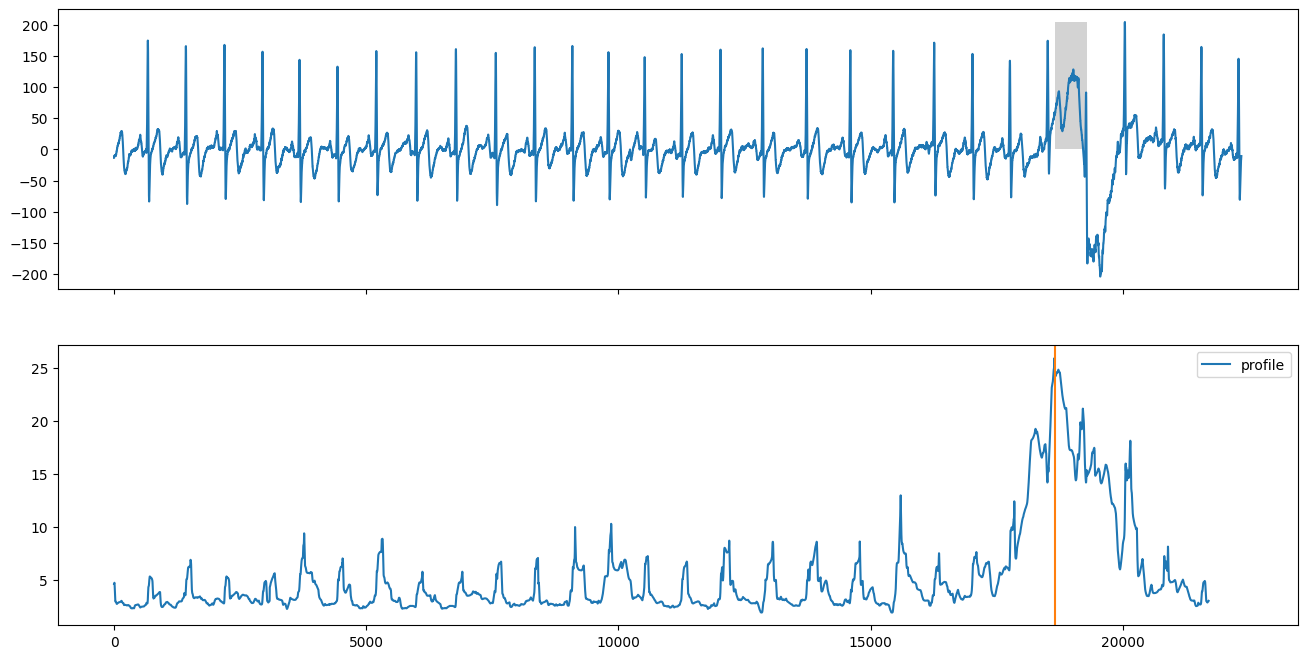

In [53]:
fig, ax = plt.subplots(2, figsize=(16,8), sharex=True)
g1 = sns.lineplot(y=y, x=x, ax=ax[0])
g2 = sns.lineplot(data=profile_df, ax=ax[1])


rect = Rectangle((discord.index[0], 0), m, max(y), facecolor="lightgrey")
g1.add_patch(rect)
g2.axvline(x=[discord.index[0]], color='C1')